In [1]:
import numpy as np
import pandas as pd
import palettable
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotting_utils import set_mpl_defaults, remove_spines, save_figure

/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


In [2]:
%matplotlib inline
set_mpl_defaults(mpl)
set1_colors     = palettable.colorbrewer.qualitative.Set1_9.mpl_colors
dark2_colors    = palettable.colorbrewer.qualitative.Dark2_8.mpl_colors
paired12_colors = palettable.colorbrewer.qualitative.Paired_12.mpl_colors

In [3]:
kenya = pd.read_csv("kenya-life-table.csv")
kenya.ix[:,0].unique()

array(['Indicator', 'nMx - age-specific death rate between ages x and x+n',
       'nqx - probability of dying between ages x and x+n',
       'lx - number of people left alive at age x',
       'ndx - number of people dying between ages x and x+n',
       'nLx - person-years lived between ages x and x+n',
       'Tx - person-years lived above age x',
       'ex - expectation of life at age x'], dtype=object)

Get $l_x$, the number of people left alive at age x (start of interval)

In [6]:
rows = kenya.ix[:,0].apply(lambda s: s.startswith('lx'))
#lx = kenya.ix[rows, (1, 2, 3)] # columns 2 and 3 are 2013 females and males
lx = kenya.ix[rows, (1, 8, 9)] # columns 8 and 9 are 1990 females and males
lx.reset_index(drop=True, inplace=True)

Get start of intervals

In [7]:
lx.ix[:,0] = lx.ix[:,0].str.extract('(\d+)')
lx.ix[0,0] = 0

Tidy up

In [8]:
lx = lx.convert_objects(convert_numeric=True)
lx.columns = ['age', 'males', 'females']

Add missing ages, with missing values for $l_x$

In [9]:
for a in range(int(lx.age.max())):
    if a not in lx.age.values:
        lx.loc[len(lx)] = [a, np.nan, np.nan]

Sort by age

In [10]:
lx.sort(columns='age', inplace=True)
lx.reset_index(inplace=True, drop=True)

Interpolate values

In [11]:
lx.males.interpolate(method='linear', inplace=True)
lx.females.interpolate(method='linear', inplace=True)

Add deaths that occured in "x"-th year of life

In [12]:
lx['total'] = lx.males + lx.females
lx['deaths'] = lx.total.diff(-1)

Assume everyone in the last age dies that year.

In [13]:
lx.ix[len(lx) - 1, 'deaths'] = lx.ix[len(lx) - 1, 'total']

Check that everyone dies

In [14]:
print "total born:", lx.ix[0, 'total']
print "total deaths:", sum(lx.deaths)

total born: 200000.0
total deaths: 200000.0


Probability lifespan is _x_ years is just proportion of deaths occuring at age _x_.

In [15]:
total_born = lx.ix[0, 'total']
lx['lifespan_pmf'] = lx.deaths / total_born

Check out the lifespan distribution

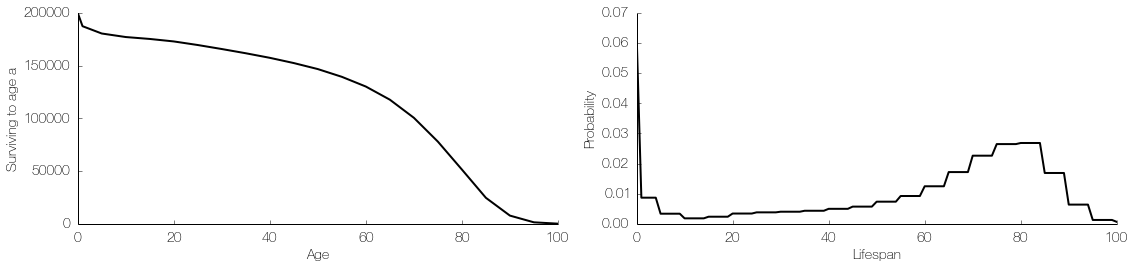

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ax = axes[0]
ax.plot(lx.total)
ax.set_ylabel('Surviving to age a')
ax.set_xlabel('Age')
remove_spines(ax)

ax = axes[1]
ax.plot(lx.lifespan_pmf)
ax.set_ylabel('Probability')
ax.set_xlabel('Lifespan')
remove_spines(ax)
fig.tight_layout()
#save_figure(fig, "kenya-lifespan")

Check life expectancy (should be around 61.08 for 2012, 59.12 for 1990, according to Google)

In [20]:
print 'life expectancy', (lx.lifespan_pmf * lx.age).sum()

life expectancy 59.6212705


Output a JSON file to use for simulations

In [21]:
with open("kenya_lifespan_pmf_1990.json", 'w') as f:
    f.write('{{ "pmf": {} }}'.format(lx.lifespan_pmf.to_json(orient='records')))